# A Naive Bayes Model for Classifing Quantitative Text

In this notebook we will be training a naive bayes model to classify academic papers into one of eight quantitative fields. The eight categories we will be working with are the top level classifications the arXiv and can be seen by expanding the list below.

<details closed> 
<summary>List of categories</summary> 
Physics <br />
Mathematics (math) <br />
Computer Science (cs) <br />
Quantitative Biology (q-bio) <br />
Quantitative Finance (q-fin) <br />
Statistics (stat) <br />
Electrical Engineering and Systems Science (eess) <br />
Economics (econ) 

 </details>

In particular, we will train a multinomial naive bayes model, which assumes that the bag of words corresponding to each entry is generated by drawing from a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution). The parameters of this distribution are learned during the training phase by counting occurances of words within each category. While this approach does not take into account the relations or parts of speech of words, it should do well in this situation, which involves subject specific vocabulary.

## Imports and reading in the processed data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

PATH = 'Data/sampledPapers.pickle'


In [3]:
df = pd.read_pickle(PATH)
df.head()

,title,categories,abstract,primary
106525,IR suppression of the Coulomb gauge gluon prop...,hep-lat,We calculate the equal-time transverse gluon...,physics
42910,Continuous Neel to Bloch Transition as Thickne...,cond-mat.stat-mech cond-mat.mtrl-sci,We analyze the properties of Neel and Bloch ...,physics
1662748,Mechanically transferred large-area Ga$_2$O$_3...,cond-mat.mes-hall,We demonstrate a large-area passivation laye...,physics
671832,Ultra-stripped supernovae and double neutron s...,astro-ph.SR astro-ph.HE,The evolution of close-orbit progenitor bina...,physics
569113,Balanced homodyne detection with on-off detect...,quant-ph,Driven by single photon detection requiremen...,physics


## Setting up the train and test split

In our first model, we will train a naive bayes classifier on the combination of the words in the title and the abstract, and we will be disregarding the more fine grained category column.

In [4]:
df['title_and_abstract'] = df.apply(lambda row: row['title'] + ' ' + row['abstract'], axis=1)
df.drop(['title', 'abstract', 'categories'], axis=1, inplace=True)

As our classes are imbalanced, we will take a stratified sample to ensure performance among all categories and to avoid overfitting. We will use a 60-20-20 split for training, validation, and testing.

In [5]:
X_combinedtrain, X_test = train_test_split(df, train_size=0.8, stratify=df['primary'])
X_train, X_validate = train_test_split(X_combinedtrain, train_size=0.5, stratify=X_combinedtrain['primary'])
y_train, y_validate, y_test = X_train['primary'], X_validate['primary'], X_test['primary']
X_train.drop(labels=['primary'], axis=1, inplace=True)
X_validate.drop(labels=['primary'], axis=1, inplace=True)
X_test.drop(labels=['primary'], axis=1, inplace=True)

## Defining training and accuracy functions

Here, we set up a pipeline consisting of a word vectorizer followed by a multinomial naive Bayes model. Our training function has variables: `max_ngram` for the number of consecutive words considered,  `vocab_size` for the total number of words in our vectorizor's dictionary, and `alpha` for the smoothing hyper-parameter for the naive bayes model.

In [6]:
def train(X, y, max_ngram = (1,1), vocab_size = 100000, alpha = 1):
    vectorizor = ColumnTransformer([('title_and_abstract', CountVectorizer(stop_words='english', 
                                                            max_features=vocab_size,
                                                            ngram_range=max_ngram), 'title_and_abstract')],
                             remainder='drop', verbose_feature_names_out=False)
    clf = MultinomialNB(alpha=alpha)
    pipelineList = [('vectorizor', vectorizor), ('Classifier', clf)]
    classifier = Pipeline(pipelineList)
    classifier.fit(X, y)
    return classifier

def accuracy(X_test, y_test, classifier) -> float:
    y_pred = classifier.predict(X_test)
    return (y_test == y_pred).sum()/y_test.shape[0]

Let's train an initial model and evaluate its accuracy.

In [7]:
model = train(X_train, y_train, max_ngram=(1,1))

In [8]:
accuracy(X_validate, y_validate, model)

0.8058635935348264

Let's run the model on a synthetic example as well.

In [9]:
test = pd.DataFrame({'title_and_abstract' : ['The mitochondria is the powerhouse of the cell.']})
model.predict(test)[0]

'q-bio'

## Hyper-parameter tuning for the naive bayes model

### Tuning the smoothing parameter $\alpha$

The main hyperparameter for a naive Bayes model is usually denoted $\alpha$ can can be thought of as a "smoothing parameter". To understand what this hyperparamter does, let's consider an extreme example. If our model encounters a paper containing a word which did not appear in the 'physics' category during training, a standard naive bayes approach would assign a probability of zero to this being a physics paper, regardless of what information the rest of the words contain. The $\alpha$ parameter adds a small probability to each word occuring in each class. It can be interpreted as adding a new paper to each category with $\alpha$ occurances of every word in the vocabulary.

The usual default value for $\alpha$ is 1. As academic papers tend to use a well established vocabulary, it is likely that a relatively small $\alpha$ will perform better. Below we carry out an order of magnitude search for an optimal value for this parameter and evaluate the trained models on the validation sets.

In [10]:
possibleAlphas = [.001, .005, .01, .05, .1, .5, 1, 5, 10, 50, 100]
alphaAccuracies = [accuracy(X_validate, y_validate, 
                            train(X_train, y_train, alpha=alpha, max_ngram=(1,1))) for alpha in possibleAlphas]
    
    

(0.001, 0.8017322606363703)
(0.005, 0.8037798072044647)
(0.01, 0.8043596434007393)
(0.05, 0.8059904327027615)
(0.1, 0.806443429731101)
(0.5, 0.8059179531782271)
(1, 0.8058635935348264)
(5, 0.7901717764731463)
(10, 0.7728672899905776)
(50, 0.7309922446908749)
(100, 0.7132891208233674)


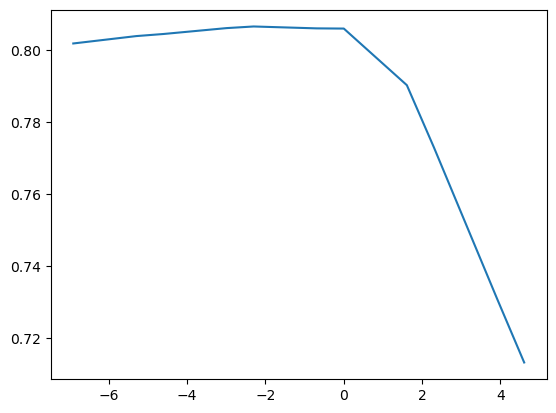

In [11]:
plt.plot(np.log(possibleAlphas), alphaAccuracies)
for i in zip(possibleAlphas,alphaAccuracies):
    print(i)

We see that the model has a relatively stable performance for small values of $\alpha$, followed by a quick dropoff into what will be a uniform model as $\alpha$ tends towards $\infty$. We will proceed with $\alpha = .5$.

### Tuning the number of consecutive words to consider

An $n$-gram consists of $n$ consecutive words in a document. Bigrams give much richer information about the meaning of a document, especially within our context. For example the word "quantum" appearing in a text greatly increases the chances of the text corresponding to a physics paper; on the other hand, "quantum cohomology" is a pure mathematics concept. Here we need to be weighing model complexity and exectution time against accuracy.

In [12]:
possibleNGrams = [1, 2, 3]
nGramAccuracies = [accuracy(X_validate, y_validate, 
                            train(X_train, y_train, alpha=.5, max_ngram=(1,n))) for n in possibleNGrams]
    

In [13]:
for i in zip(possibleNGrams, nGramAccuracies):
    print(i)

(1, 0.8059179531782271)
(2, 0.8178408349641226)
(3, 0.8174421975791839)


It is quite surprising that considering trigrams instead of bigrams did not meaningfully increase accuracy, despite the addition of model complexity. This is likely a case of overfitting. We will proceed with bigrams.

### Tuning vocabulary size

There is actually a choice we made before even training the naive Bayes model, which is the choice of vocabulary size. Again here, the choosing the appropriate vocabulary size consists of balancing some tradeoffs. Larger vocabulary sizes will result in more accurate models, but come at the expense of increased training and prediction times. As the training and prediction times are linear in the vocabulary size (all other parameters being constant) we will look for an inflection point in model accuracy.

In [14]:
vocabSizes = [100, 1000, 10000, 100000, 200000, 300000, 400000]
vocabSizeAccuracies = [accuracy(X_validate, y_validate, 
                            train(X_train, y_train, alpha=.5, vocab_size=size, max_ngram=(1,2))) for size in vocabSizes]

100 0.5190439950713923
1000 0.7337645865043125
10000 0.7992135971588027
100000 0.8178408349641226
200000 0.82131985214177
300000 0.8234217583532653
400000 0.8245451909835472


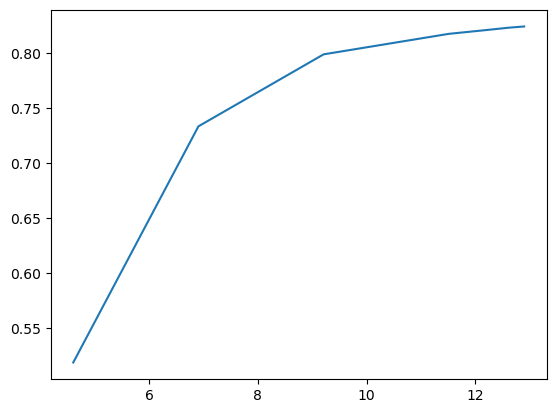

In [15]:
plt.plot(np.log(vocabSizes), vocabSizeAccuracies)
for size, acc in zip(vocabSizes, vocabSizeAccuracies):
    print(size, acc)


It is perhaps surprising how well the model does with a voabulary size of just $10000$. If speed of prediction was of the utmost importance, it would make sense to set our vocabulary size there. For our purposes, we will aim for some more accuracy. We start to see rapidly diminishing returns at a vocabulary size of $100000$, so set our voacabulary size there. 

## Evaluating and exporting the final model

We have settled on $\alpha = .5$ and a vocabulary size of $100000$ unigrams and bigrams. Let's train our final model, and get an accuracy score on the unseen test set.

In [16]:
final_model = train(X_train, y_train, alpha=.5, vocab_size=100000, max_ngram=(1,2))
accuracy(X_test, y_test, final_model)

0.8165247327414387

Let's see how this tuned model performs on each category. As we saw before, the model has an overall accuracy of about $82\%$. To get some more subtle information about misclassifications, we investigate the confusion matrix, which plots predicted labels against actual labels.

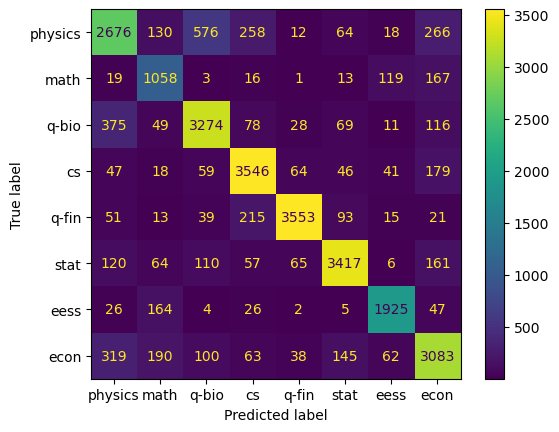

In [17]:
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['physics', 'math', 'q-bio', 'cs', 'q-fin', 'stat', 'eess', 'econ'])
disp.plot()
plt.show()

As we can see the model has a bit of trouble distinguishing between quantitative biology and physics papers, from which we can conclude that these fields use similar terminology. It does an excellent job in terms of both precision and recall for computer science and quantitative finance papers.

We can now save and export our final model. As the multinomial naive bayes classifier in sklearn saves its attributes as numpy ndarrays, we use the joblib dump function, which is made for such data structures.

In [20]:
import joblib

joblib.dump(final_model, "Models/MNBQuantitativeClassifier.joblib")

['Models/MNBQuantitativeClassifier.joblib']